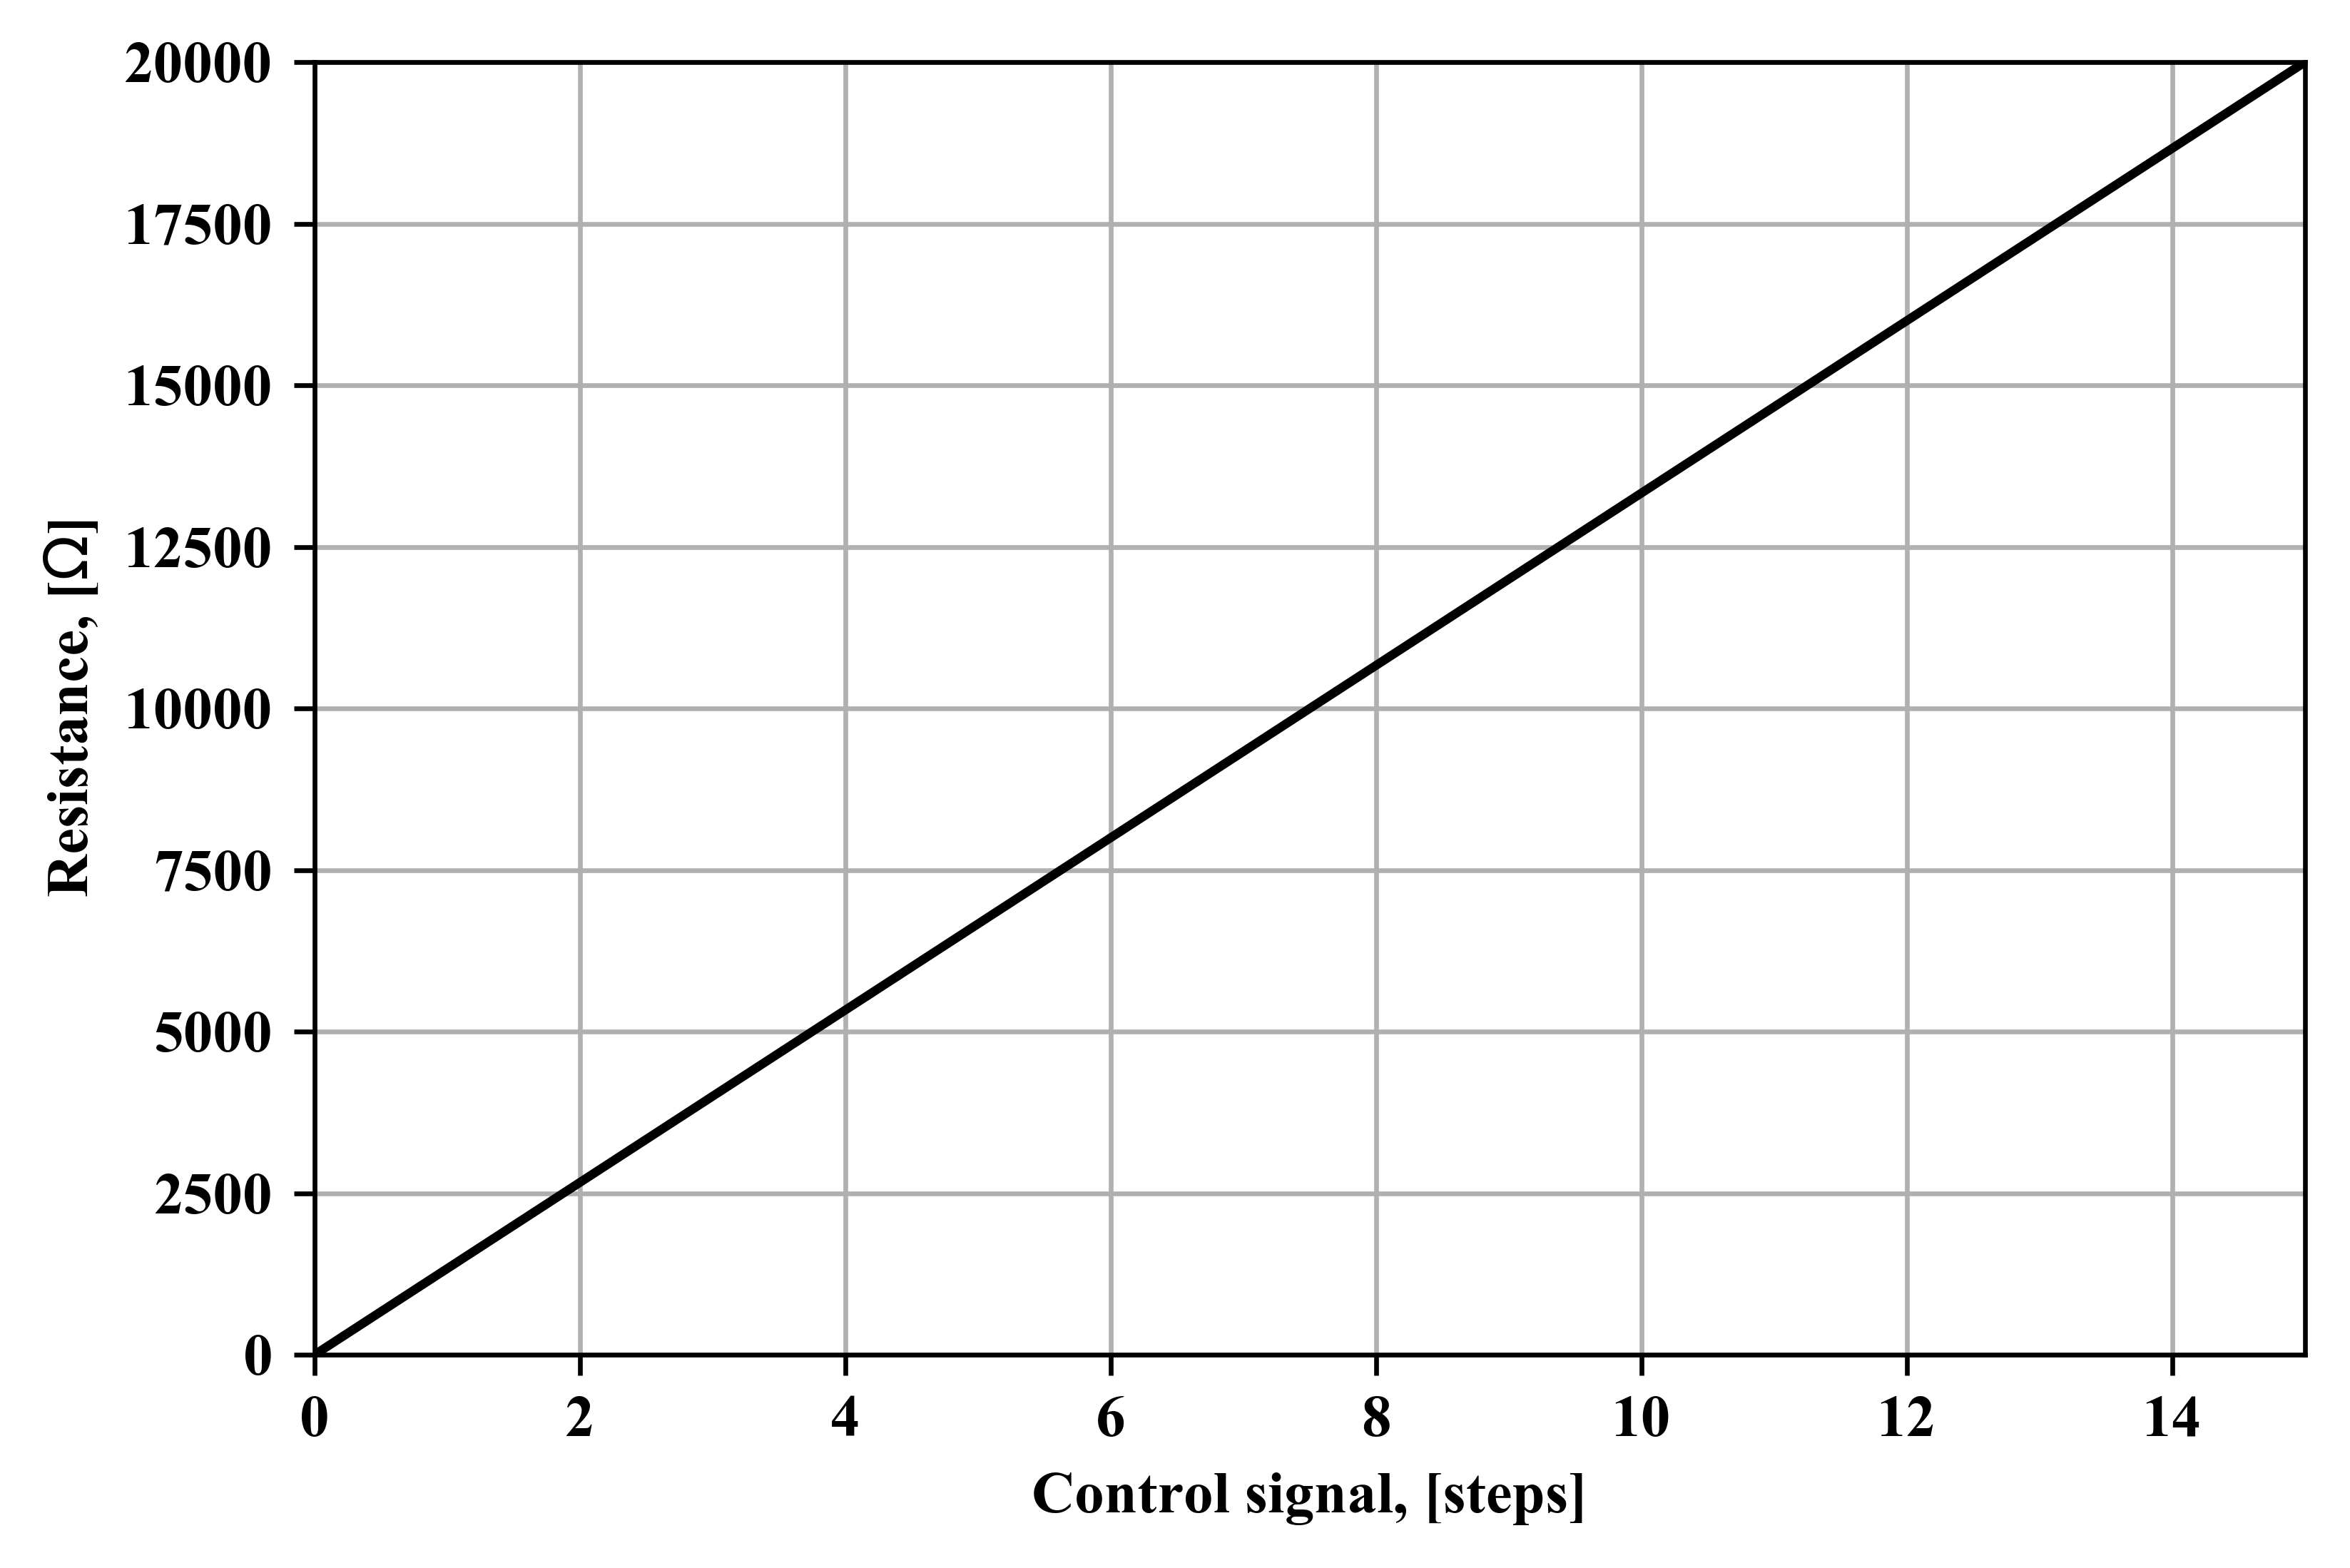

In [39]:
from math import sqrt, exp
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import random

# Some plots prettiness

# to use custom fonts, they have to be installed in system
# if font will not be found, than script will fallback to DejaVu Sans
mpl.rc('font', family="Times New Roman")
mpl.rcParams['figure.dpi']  = 600
mpl.rcParams['savefig.dpi'] = 600

figure_counter = 1

output_file = 'out.csv'
OCV_out = 'OCV_out.csv'

def add_noise(value, noise):
    if noise == 0:
        return value
    else:
        value += random.randrange(-10, 10 ,1)/10*noise
        if value >0:
            return value
        else:
            return 0

class digital_rheostat ():
    def __init__  (self, total_resistance, resolution_bits):
        self.total_resistance = total_resistance
        self.bits = resolution_bits
        self.resolution =  pow(2, self.bits)-1
        self.step = round(self.total_resistance/self.resolution, 2)
        self.balast = round(self.total_resistance - (self.resolution)*self.step, 2)
        self.resistance_map = enumerate ([round((self.balast + self.step * step),2) for step in range(self.resolution+1)])
    def print_info (self):
        print ("Resolution, steps \t:", self.resolution+1, '( from 0 to', self.resolution, ")\nBalast resistance, Ohms :",self.balast, "\nStep resistance, Ohms \t:", self.step)
    def print_map (self):
        for number, value in self.resistance_map:
            print(number, value)    
    def print_raw_map(self):
        resistors = [i[1] for i in self.resistance_map]
        print (resistors)
        print (len(resistors))
        print (list(range(self.resolution+1)))
    
    def plot_load(self):
        # if plot was not creater earlier - create it
        if not hasattr(self, 'plot'):        
            self.plot = mpl.pyplot
            # pointing to global variable
            global figure_counter
            self.plot.figure(figure_counter)
            figure_counter+=1
            # print datapoints, connected with black lines
            x = list(range(self.resolution+1))
            y = [i[1] for i in self.resistance_map]
            self.plot.plot(x, y, "k")
            # adds actual data point to plot marked as blue rounds
            #plt.plot(x, y, "bo")
            # value in $$ will be rendered as LATEX, very usefull for special characters
            self.plot.ylabel(r'Resistance, [$\Omega$]')
            self.plot.xlabel('Control signal, [steps]')
            self.plot.axis([0, self.resolution, 0, self.total_resistance])
            self.plot.grid(True)
        # show the plot
        self.plot.show()        
            
# maximal resistance that can be achieved in rheostat
RHEOSTAT = 20000
# resolution bit of rheostat / potentiometer
RESOLUTION = 4
DIGIPOT = digital_rheostat(RHEOSTAT, RESOLUTION)
DIGIPOT.plot_load()

[0, 50, 100, 300, 400, 650, 950]
[50, 50, 75, 810, 1000, 975, 0]


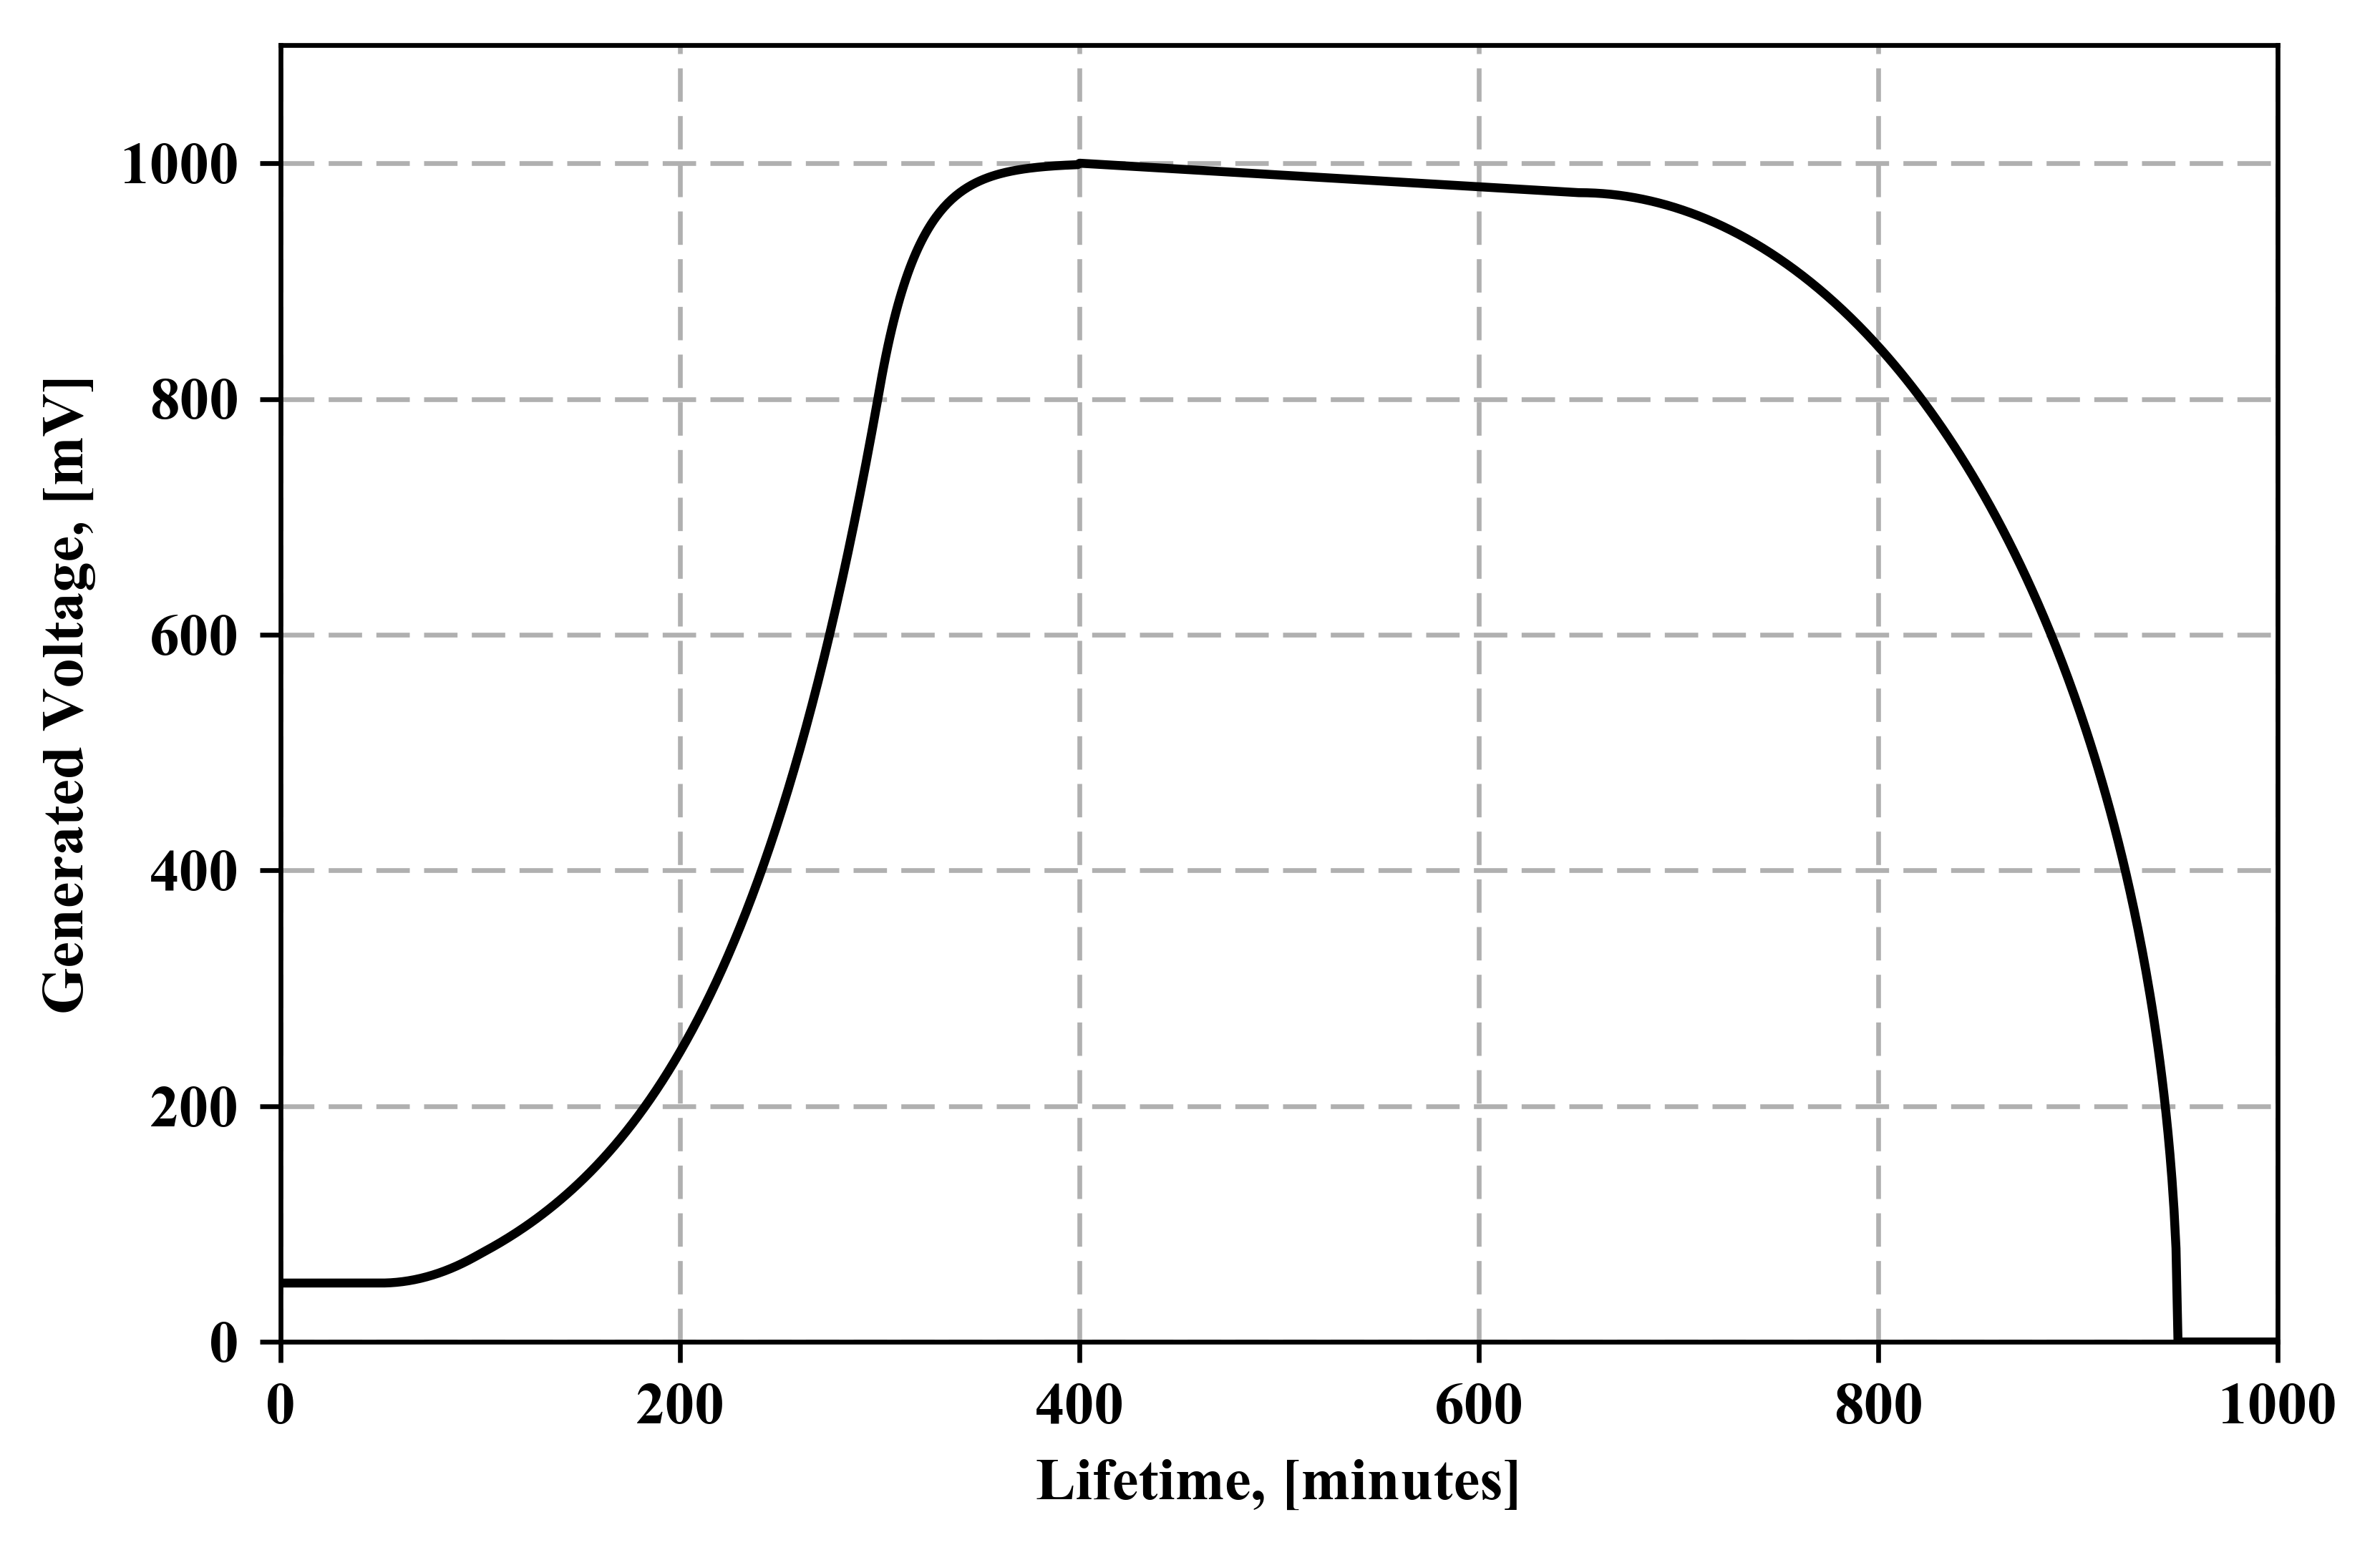

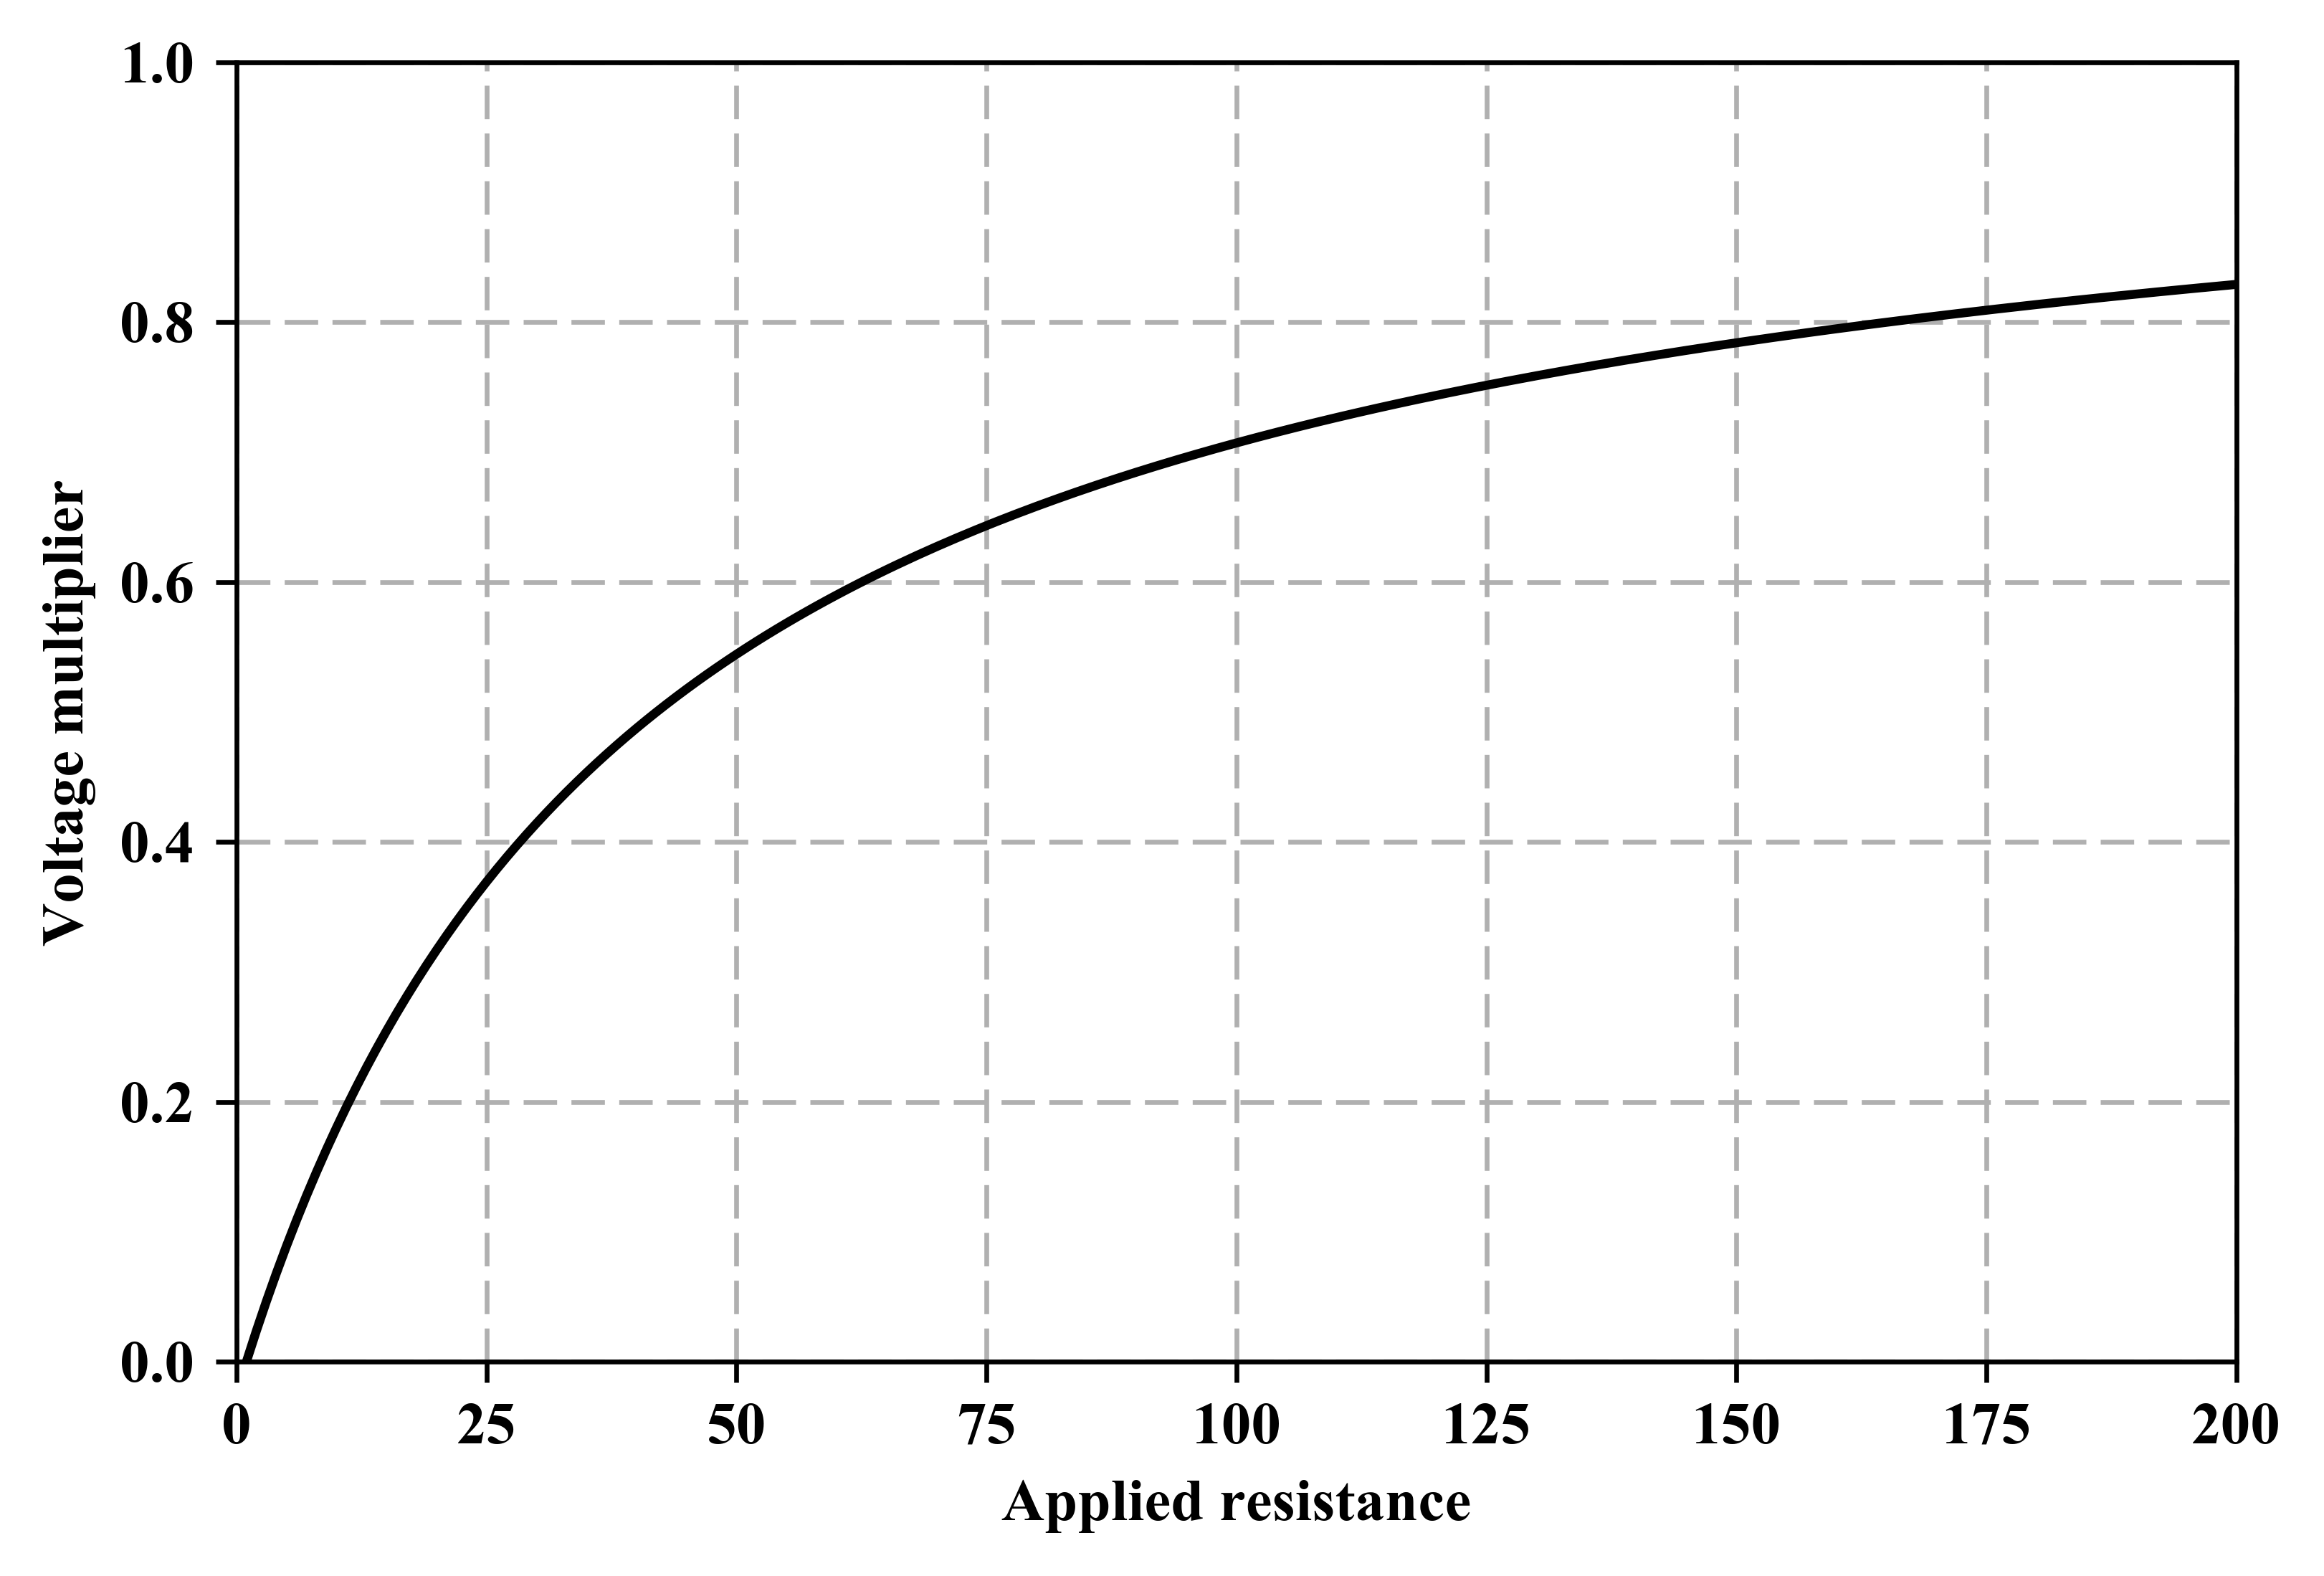

In [40]:
class MFC_batch ():
    def __init__ (self, max_load, lifetime, K, noise = 0):
        self.K = K
        self.lifetime = lifetime
        self.max_load = max_load
        self.noise = noise
        
        time_coeficients = [0, 0.05, 0.1, 0.3, 0.4, 0.65, 0.95]
        self.T = [round(self.lifetime*coeficient) for coeficient in time_coeficients]
        self.voltages = [50, 50, 75, 600, 1000, 975, 0]
        self.voltages[3] = round(self.voltages[2]/exp(self.K*(self.T[2]-self.T[3])))
        
    def print_map (self):
        print (self.T)
        print (self.voltages)
        
    def get_voltage_by_time (self, time_point):       
        # Lag phase, before T1
        if time_point < self.T[1]:
            return self.voltages[0]
        # Acceleration phase, between T1 and T2
        elif time_point < self.T[2]:
            #return self.voltages[1]+(self.voltages[2]-self.voltages[1])*pow((time_point - self.T[1]/self.T[2] - self.T[1])/100, 2)
            multiplier = (time_point - self.T[1])/(self.T[2] - self.T[1])
            # original equation had a mistake:
            # multiplier = time_point - self.T[1]/self.T[2] - self.T[1]
            return self.voltages[1]+(self.voltages[2]-self.voltages[1])*pow(multiplier, 2)
        # Log phase (Exponential phase), between  T2 and T3
        elif time_point < self.T[3]:
            return self.voltages[3]*exp(self.K*(time_point-self.T[3]))
        # Decline phase
        elif time_point < self.T[4]:
            a = self.K*self.voltages[3]*(time_point-self.T[3])/(self.voltages[4]-self.voltages[3])
            return self.voltages[4] - (self.voltages[4]-self.voltages[3])/exp(a)
        # Stationary phase
        elif time_point < self.T[5]:
            #return self.voltages[4]
            k = (self.voltages[5]-self.voltages[4])/(self.T[5]-self.T[4])
            b = self.voltages[4] - self.T[4]*k
            return time_point*k+b
        # Death phase
        elif time_point < self.T[6]:
            t = time_point-self.T[5]
            a = self.T[6]-self.T[5]
            b = self.voltages[5]
            return b*sqrt(1 - pow(t/a, 2))            
        # Dead MFC
        else:
            return 0
        
    def get_multiplier (self, resistance):
        half_power_resistance = self.max_load/5
        return (resistance-1)/(resistance + half_power_resistance)  
    
    def multiplier_curve (self):
        self.multiplier_plot = mpl.pyplot
        global figure_counter
        self.multiplier_plot.figure(figure_counter)
        figure_counter+=1
        
        x = [i for i in range(self.max_load+1)]
        y = [self.get_multiplier(i) for i in range(self.max_load+1)]
        
        self.multiplier_plot.plot(x, y, "k")
        
        self.multiplier_plot.axis([0, self.max_load, 0, 1])
        self.multiplier_plot.grid(linestyle='--')
        self.multiplier_plot.ylabel('Voltage multiplier')
        self.multiplier_plot.xlabel('Applied resistance')
        
        self.multiplier_plot.show()
    
    def voltage_curve(self):
        #voltages = voltages = [self.get_voltage_by_time(time) for time in range(self.lifetime+1)]
        self.voltage_plot = mpl.pyplot
        # pointing to global variable
        global figure_counter
        self.voltage_plot.figure(figure_counter)
        figure_counter+=1
        # print datapoints, connected with black lines
        x = list(range(self.lifetime+1))
        y = [self.get_voltage_by_time(time) for time in range(self.lifetime+1)]
        self.voltage_plot.plot(x, y, "k")
        # adds actual data point to plot marked as blue rounds
        #plt.plot(x, y, "bo")
        # value in $$ will be rendered as LATEX, very usefull for special characters
        self.voltage_plot.ylabel('Generated Voltage, [mV]')
        self.voltage_plot.xlabel('Lifetime, [minutes]')
        self.voltage_plot.axis([0, self.lifetime, 0, max(y)+100])
        self.voltage_plot.grid(linestyle='--')
        # show the plot
        self.voltage_plot.show()
    
    def voltage_profile(self):
        if not hasattr(self, 'profile'): 
            with open(output_file, 'w', newline='') as csvfile:
                spamwriter = csv.writer(csvfile, delimiter=',')
                spamwriter.writerow(['Time','Load','Voltage','Power',])
                spamwriter.writerow(['iterations','Ohms','mV','uWt',])
                for time in range(self.lifetime+1):
                    time_voltage = round(self.get_voltage_by_time(time), 3)
                    for r in range (1, self.max_load+1):
                        voltage = add_noise(time_voltage, self.noise)
                        multiplier = round(self.get_multiplier(r), 3)
                        voltage = round(multiplier * voltage, 3)
                        power = round(pow(voltage,2)/r, 3)
                        #print (time, time_voltage, r, multiplier, voltage, power)                        
                        spamwriter.writerow( [time, r, voltage, power])
            
    
fuel = MFC_batch(200, 1000, 0.0119, noise = 50)
fuel.print_map()
fuel.voltage_curve()
fuel.multiplier_curve()
fuel.voltage_profile()

In [41]:
fuel.print_map()

[0, 50, 100, 300, 400, 650, 950]
[50, 50, 75, 810, 1000, 975, 0]
